In [16]:
#import the required libraries

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s

#Next, we will define the model architecture which will be similar to what we had while training the model:
base_model = VGG16(weights='imagenet', include_top=False)

In [17]:
#This is the pre-trained model and we will fine-tune it next:

#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [18]:
#Now, as we have defined the architecture,
# we will now load the trained weights which we stored as weights_skate.hdf5:

# loading the trained weights
model.load_weights("weights_skate.hdf5")

In [19]:
#Compile the model as well

# compiling the model
#Make sure that the loss function, optimizer, and the metrics are the same as we used while training the model.
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
# tf_model = tf.keras.models.Model(model)
# tf.saved_model.save(tf_model, "saved_model_keras_dir")
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
# tflite_model = converter.convert()
# 
# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [20]:
# there is a file named “testlist_skate.txt” which contains the list of test videos. We will make use of that to create the test data:

#Creating the test data
# getting the test list
f = open("datas/testlist_skate.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating the dataframe
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]
test_videos = test['video_name']
test.head()

,video_name
0,Fails/Fail_070.mp4
1,Fails/Fail_071.mp4
2,Fails/Fail_072.mp4
3,Fails/Fail_073.mp4
4,Fails/Fail_074.mp4


In [21]:
#We now have the list of all the videos stored in a dataframe.
# To map the predicted categories with the actual categories,
# we will use the train_new.csv file:

# creating the tags
train = pd.read_csv('datas/train_skate.csv')
y = train['class']
y = pd.get_dummies(y)

In [31]:
#Generating predictions for the test videos

#1. First, we will create two empty lists – one to store the predictions and the other to store the actual tags
prediction_inputs = []
predict = []
actual = []

#2. Then, we will take each video from the test set,
# extract frames for this video and store it in a folder (create a folder named temp in the current directory to store the frames).
# We will remove all the other files from this folder at each iteration

#3. Next, we will read all the frames from the temp folder,
#extract features for these frames using the pre-trained model,
# predict tags, and then take the mode to assign a tag for that particular video and append it in the list

#4. We will append actual tags for each video in the second list

# for loop to extract frames from each test video
for i in tqdm(range(test_videos.shape[0])):
    count = 0
    videoFile = test_videos[i]
    #print(videoFile)
    cap = cv2.VideoCapture('datas/Videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    # removing all other files from the temp folder
    files = glob('datas/temp/*')
    for f in files:
        os.remove(f)
    while cap.isOpened():
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if not ret :
            break
        if frameId % math.floor(frameRate) == 0:
            # storing the frames of this particular video in temp folder
            filename ='datas/temp/' + "_frame" + str(count) + ".jpg"
            count+=1
            cv2.imwrite(filename, frame)
    cap.release()

    # reading all the frames from temp folder
    images = glob("datas/temp/*.jpg")

    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)

    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction_inputs.append(prediction_images)
    prediction = model.predict_classes(prediction_images)
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(y.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(videoFile.split('/')[1].split('_')[0])

100%|██████████| 60/60 [01:49<00:00,  1.82s/it]


96.66666666666667


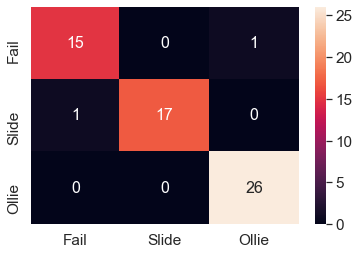

In [40]:
#Once we have the predictions,
# we will calculate the performance of the model.
LABELS = ['Fail', 'Slide', 'Ollie']
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(predict, actual)*100)

predicted_categories = [LABELS.index(x) for x in predict]
true_categories = [LABELS.index(x) for x in actual]
conf_matrix = confusion_matrix(predicted_categories, true_categories)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(conf_matrix, LABELS, LABELS)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
